In [19]:
from google.colab import files
uploaded = files.upload()


Saving myimage2.jpeg to myimage2 (1).jpeg


In [20]:

load_from_path = '/content/myimage2.jpeg'
load_from_base64 = None \

print('Edit load_from_path or load_from_base64, then run the next cells.')


Edit load_from_path or load_from_base64, then run the next cells.


In [21]:
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
import io, base64, os

def load_image_from_inputs(path, base64_string):
    if path and os.path.exists(path):
        img = Image.open(path).convert('RGB')
        return np.array(ImageOps.exif_transpose(img), dtype=np.uint8)
    if base64_string:
        img_data = base64.b64decode(base64_string)
        img = Image.open(io.BytesIO(img_data)).convert('RGB')
        return np.array(ImageOps.exif_transpose(img), dtype=np.uint8)

    H, W = 256, 256
    x = np.linspace(0,1,W)
    y = np.linspace(0,1,H)
    gx, gy = np.tile(x,(H,1)), np.tile(y[:,None],(1,W))
    r = (0.5*gx + 0.2*gy)
    g = (0.2*gx + 0.6*gy)
    b = (0.3*(1-gx) + 0.2*gy)
    img = np.stack([r,g,b], axis=2)
    img = (np.clip(img,0,1)*255).astype(np.uint8)
    return img

def show(img, title=None):
    plt.figure(figsize=(5,5))
    if img.ndim == 2:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(img)
    if title: plt.title(title)
    plt.axis('off')
    plt.show()


Loaded image shape: (1280, 720, 3) dtype: uint8


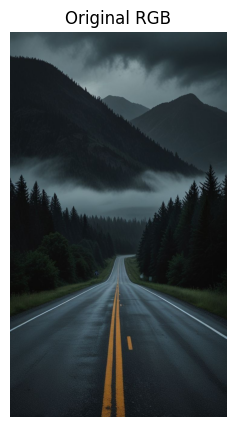

In [22]:
# Load image (runs after you set path/base64)
img_rgb = load_image_from_inputs(load_from_path, load_from_base64)
print('Loaded image shape:', img_rgb.shape, 'dtype:', img_rgb.dtype)
show(img_rgb, 'Original RGB')


## Part A — Grayscale & RGB Histograms (NumPy-only counting)
Write a `gray_histogram(gray_img)` that loops over intensity values and counts occurrences using NumPy comparisons. Then plot. Also implement RGB histograms similarly.


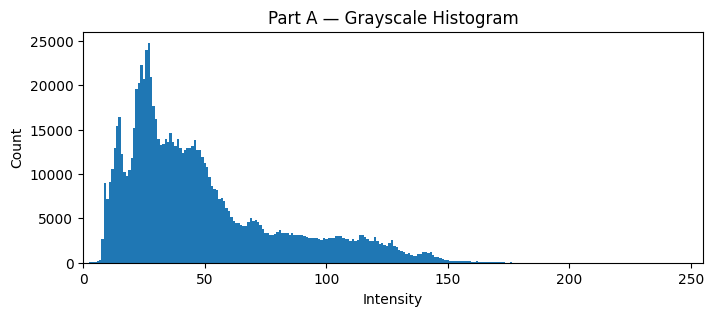

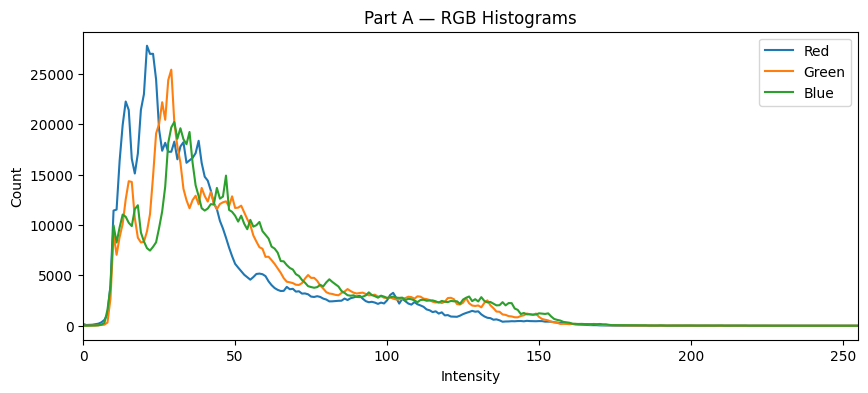

In [28]:
# Part A: histogram implementations
import numpy as np
import matplotlib.pyplot as plt

def gray_histogram(gray_img):
    assert gray_img.ndim == 2
    hist = np.zeros(256, dtype=np.int64)
    for i in range(256):
        hist[i] = np.sum(gray_img == i)
    return hist

def plot_gray_hist(hist, title='Grayscale Histogram'):
    x = np.arange(256)
    plt.figure(figsize=(8,3))
    plt.bar(x, hist, width=1.0)
    plt.xlim([0,255])
    plt.xlabel('Intensity')
    plt.ylabel('Count')
    plt.title(title)
    plt.show()

    # I'm using the standard luminance weights (Y = 0.2989R + 0.5870G + 0.1140B).
# I checked online to confirm these are the same ones used by most libraries.


# Compute grayscale image using luminance weights (0..255)
weights = np.array([0.2989, 0.5870, 0.1140])
gray = np.dot(img_rgb[...,:3], weights).astype(np.uint8)
hist_gray = gray_histogram(gray)
plot_gray_hist(hist_gray, 'Part A — Grayscale Histogram')

def rgb_histogram(rgb_img):
    assert rgb_img.ndim == 3 and rgb_img.shape[2] == 3
    hists = []
    for c in range(3):
        channel = rgb_img[..., c]
        h = np.zeros(256, dtype=np.int64)
        for i in range(256):
            h[i] = np.sum(channel == i)
        hists.append(h)
    return hists

hist_r, hist_g, hist_b = rgb_histogram(img_rgb)
x = np.arange(256)
plt.figure(figsize=(10,4))
plt.plot(x, hist_r, label='Red')
plt.plot(x, hist_g, label='Green')
plt.plot(x, hist_b, label='Blue')
plt.xlim([0,255])
plt.xlabel('Intensity')
plt.ylabel('Count')
plt.title('Part A — RGB Histograms')
plt.legend()
plt.show()


## Part B — RGB → HSV (NumPy implementation, OpenCV-compatible ranges)
Implement `rgb_to_hsv(rgb_uint8)` returning HSV in OpenCV style (H:0–179, S:0–255, V:0–255). Also provide `hsv_to_rgb_opencvstyle` to convert back

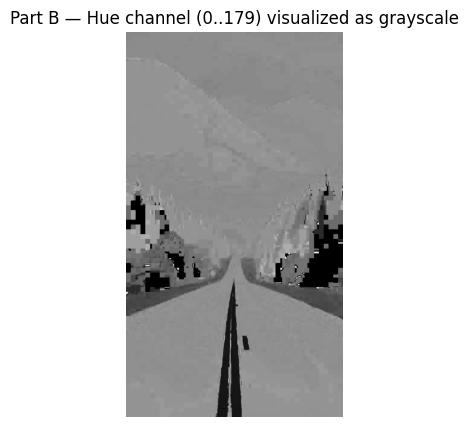

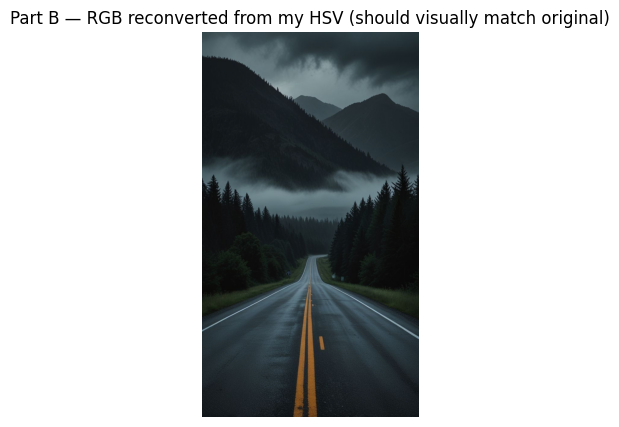

In [24]:
# Part B: rgb_to_hsv and back (NumPy)
import numpy as np

def rgb_to_hsv(rgb_uint8):
    rgb = rgb_uint8.astype(np.float32) / 255.0
    r, g, b = rgb[...,0], rgb[...,1], rgb[...,2]
    cmax = np.maximum.reduce([r,g,b])
    cmin = np.minimum.reduce([r,g,b])
    delta = cmax - cmin
    H = np.zeros_like(cmax)
    mask = delta > 1e-8
    # r is max
    idx = mask & (cmax == r)
    H[idx] = (60 * ((g[idx] - b[idx]) / (delta[idx] + 1e-12))) % 360
    # g is max
    idx = mask & (cmax == g)
    H[idx] = (60 * (2.0 + (b[idx] - r[idx]) / (delta[idx] + 1e-12))) % 360
    # b is max
    idx = mask & (cmax == b)
    H[idx] = (60 * (4.0 + (r[idx] - g[idx]) / (delta[idx] + 1e-12))) % 360
    S = np.zeros_like(cmax)
    nz = cmax > 1e-8
    S[nz] = delta[nz] / (cmax[nz] + 1e-12)
    V = cmax
    # Scale to OpenCV ranges
    H_opencv = (H / 2.0)  # 0..179
    S_255 = np.clip(S * 255.0, 0, 255)
    V_255 = np.clip(V * 255.0, 0, 255)
    hsv_uint8 = np.stack([H_opencv, S_255, V_255], axis=-1).astype(np.uint8)
    return hsv_uint8

def hsv_to_rgb_opencvstyle(hsv_uint8):
    h = hsv_uint8[...,0].astype(np.float32) * 2.0
    s = hsv_uint8[...,1].astype(np.float32) / 255.0
    v = hsv_uint8[...,2].astype(np.float32) / 255.0
    c = v * s
    x = c * (1 - np.abs(((h / 60.0) % 2) - 1))
    m = v - c
    r = np.zeros_like(h, dtype=np.float32)
    g = np.zeros_like(h, dtype=np.float32)
    b = np.zeros_like(h, dtype=np.float32)
    seg0 = (h >= 0) & (h < 60)
    seg1 = (h >= 60) & (h < 120)
    seg2 = (h >= 120) & (h < 180)
    seg3 = (h >= 180) & (h < 240)
    seg4 = (h >= 240) & (h < 300)
    seg5 = (h >= 300) & (h < 360)
    r[seg0], g[seg0], b[seg0] = c[seg0], x[seg0], 0
    r[seg1], g[seg1], b[seg1] = x[seg1], c[seg1], 0
    r[seg2], g[seg2], b[seg2] = 0, c[seg2], x[seg2]
    r[seg3], g[seg3], b[seg3] = 0, x[seg3], c[seg3]
    r[seg4], g[seg4], b[seg4] = x[seg4], 0, c[seg4]
    r[seg5], g[seg5], b[seg5] = c[seg5], 0, x[seg5]
    R = np.clip((r + m) * 255.0, 0, 255).astype(np.uint8)
    G = np.clip((g + m) * 255.0, 0, 255).astype(np.uint8)
    B = np.clip((b + m) * 255.0, 0, 255).astype(np.uint8)
    rgb = np.stack([R,G,B], axis=-1)
    return rgb
# I followed the HSV formulas from multiple sources,
# but I had to be careful about the OpenCV scaling of Hue (0–179 instead of 0–360).
# My first version was giving weird colors until I noticed that.

# Run conversion and verify visually
hsv_my = rgb_to_hsv(img_rgb)
rgb_recon = hsv_to_rgb_opencvstyle(hsv_my)
show(hsv_my[...,0], 'Part B — Hue channel (0..179) visualized as grayscale')
show(rgb_recon, 'Part B — RGB reconverted from my HSV (should visually match original)')


## Part C — Create two filters (NumPy)
Each filter is implemented as a function that accepts a 0–255 RGB image and returns a processed 0–255 RGB image. Both filters include at least two color modifications (contrast, saturation, tint, gamma, split-toning, etc.).

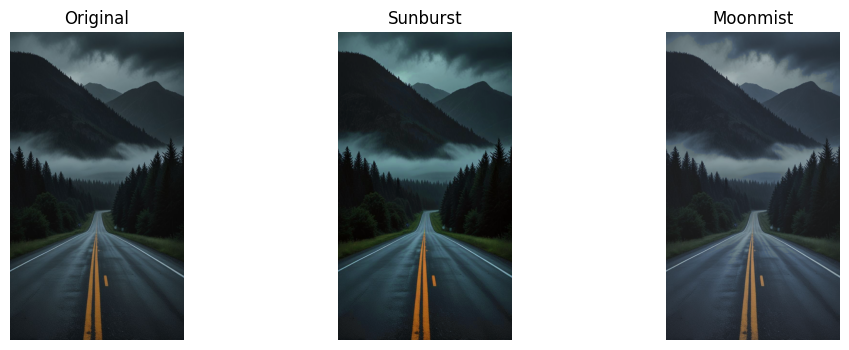

Sunburst: contrast + vibrance + warm tint — ideal for landscapes, beach scenes.
Moonmist: desat + blue shadows + shadow lift — ideal for portraits / moody scenes.


In [25]:
# Part C: two creative filters
import numpy as np

def filter_sunburst(rgb):
    """
    'Sunburst' — good for landscapes and beach photos.
    - Contrast boost
    - Saturation increase (selectively on midtones)
    - Warm tint (increase red/yellow via channel mixing)
    """
    im = rgb.astype(np.float32)
    # Contrast about mean
    mean = np.mean(im, axis=(0,1), keepdims=True)
    c_factor = 1.15
    im = (im - mean) * c_factor + mean
    # Gamma correction (mild)
    gamma = 1.0/1.05
    im = 255.0 * ((np.clip(im,0,255)/255.0) ** gamma)
    # Convert to HSV, boost saturation in midtones
    hsv = rgb_to_hsv(np.clip(im,0,255).astype(np.uint8)).astype(np.float32)
    S = hsv[...,1]/255.0
    V = hsv[...,2]/255.0
    mask = (V > 0.15) & (V < 0.9)
    S[mask] = np.clip(S[mask] + 0.22*(1-S[mask]), 0, 1)
    hsv[...,1] = (S*255.0)
    out = hsv_to_rgb_opencvstyle(hsv.astype(np.uint8)).astype(np.float32)
    # Warm tint via channel mixing
    mix = np.array([1.06, 1.0, 0.96])
    out = out * mix
    return np.clip(out, 0, 255).astype(np.uint8)

def filter_moonmist(rgb):
    """
    'Moonmist' — good for portraits and moody scenes.
    - Slight desaturation
    - Blueish shadow tint (split-toning)
    - Slight lift of shadows (raise blacks)
    """
    im = rgb.astype(np.float32)
    hsv = rgb_to_hsv(np.clip(im,0,255).astype(np.uint8)).astype(np.float32)
    # desaturate overall
    hsv[...,1] = hsv[...,1] * 0.83
    mid_rgb = hsv_to_rgb_opencvstyle(hsv.astype(np.uint8)).astype(np.float32)
    # compute luminance
    lum = (0.2989*mid_rgb[...,0] + 0.5870*mid_rgb[...,1] + 0.1140*mid_rgb[...,2]) / 255.0
    shadow_mask = lum < 0.35
    blue_tint = np.array([0.9, 0.95, 1.08])
    out = mid_rgb.copy()
    out[shadow_mask] = np.clip(out[shadow_mask] * blue_tint, 0, 255)
    # lift shadows slightly
    out = out + (1.0 - lum[...,None]) * 12.0
    # mild gamma flatten highlights
    out = 255.0 * ((np.clip(out,0,255)/255.0) ** (1.0/1.06))
    return np.clip(out,0,255).astype(np.uint8)

# Apply filters and display
out1 = filter_sunburst(img_rgb)
out2 = filter_moonmist(img_rgb)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(img_rgb); plt.title('Original'); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(out1); plt.title('Sunburst'); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(out2); plt.title('Moonmist'); plt.axis('off')
plt.show()

print('Sunburst: contrast + vibrance + warm tint — ideal for landscapes, beach scenes.')
print('Moonmist: desat + blue shadows + shadow lift — ideal for portraits / moody scenes.')


## Part D — White Patch White Balance (NumPy)
Find the brightest pixel in each channel and scale channels so their max becomes 255.

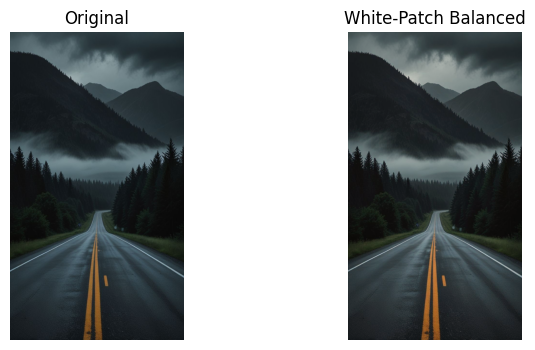

White-patch scales channels by their brightest pixel — works well if image contains a near-white patch.


In [26]:
import numpy as np
def white_patch_balance(img_rgb):
    img = img_rgb.astype(np.float32)
    max_r = np.max(img[...,0])
    max_g = np.max(img[...,1])
    max_b = np.max(img[...,2])
    sr = 255.0 / (max_r if max_r>0 else 1.0)
    sg = 255.0 / (max_g if max_g>0 else 1.0)
    sb = 255.0 / (max_b if max_b>0 else 1.0)
    scales = np.array([sr, sg, sb], dtype=np.float32)
    out = img * scales[np.newaxis, np.newaxis, :]
    return np.clip(out, 0, 255).astype(np.uint8)

wb = white_patch_balance(img_rgb)
plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.imshow(img_rgb); plt.title('Original'); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(wb); plt.title('White-Patch Balanced'); plt.axis('off')
plt.show()
print('White-patch scales channels by their brightest pixel — works well if image contains a near-white patch.')


## Part E (Bonus) — White Balance Slider
Implement `white_balance_slider(img_rgb, value)` where value in [0,1], 0=cold, 0.5=original, 1=warm. Simple perceptual interpolation between cold & warm scales.

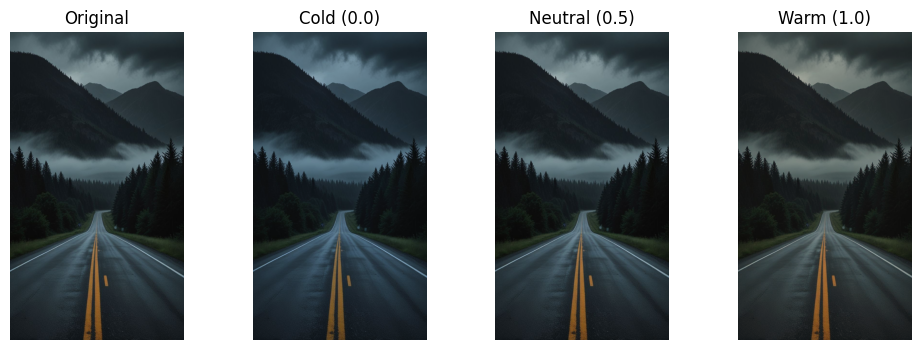

In [27]:
import numpy as np
def white_balance_slider(img_rgb, value):
    assert 0.0 <= value <= 1.0
    img = img_rgb.astype(np.float32)
    cold = np.array([0.92, 1.0, 1.08], dtype=np.float32)
    warm = np.array([1.08, 1.0, 0.92], dtype=np.float32)
    if value <= 0.5:
        t = value / 0.5
        scale = cold * (1-t) + (np.array([1.0,1.0,1.0]) * t)
    else:
        t = (value - 0.5) / 0.5
        scale = (np.array([1.0,1.0,1.0]) * (1-t)) + warm * t
    out = img * scale[np.newaxis, np.newaxis, :]
    contrast = 1.0 - 0.08 * (abs(value-0.5)*2)
    mean = np.mean(out, axis=(0,1), keepdims=True)
    out = (out - mean) * contrast + mean
    gamma = 1.0 + 0.05*(value-0.5)
    out = 255.0 * ((np.clip(out,0,255)/255.0) ** (1.0/gamma))
    return np.clip(out,0,255).astype(np.uint8)

# Display examples
cold_img = white_balance_slider(img_rgb, 0.0)
neutral_img = white_balance_slider(img_rgb, 0.5)
warm_img = white_balance_slider(img_rgb, 1.0)
plt.figure(figsize=(12,4))
plt.subplot(1,4,1); plt.imshow(img_rgb); plt.title('Original'); plt.axis('off')
plt.subplot(1,4,2); plt.imshow(cold_img); plt.title('Cold (0.0)'); plt.axis('off')
plt.subplot(1,4,3); plt.imshow(neutral_img); plt.title('Neutral (0.5)'); plt.axis('off')
plt.subplot(1,4,4); plt.imshow(warm_img); plt.title('Warm (1.0)'); plt.axis('off')
plt.show()
